In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from bing_helper import load_json_files, get_hits_from_json, load_lang_news_hits
from regression import fit_regression_and_rename_coeffs_by_cat, fit_regression_and_rename_coeffs, write_reg_results
from processing import filter_by_region_cat_code, build_regression_dataframe, load_preprocessed_events
from plot_regression import plot_regression_results, plot_regression_results_interactions, plot_country_counts, plot_regression_results_interactions_from_dict, plot_cat_by_cat_variable
from preprocessing import load_if_in_country_or_lang
from steinkasserer.preprocessing import categorize_views_for_df

%load_ext autoreload
%autoreload 2

## load Data


In [3]:
df_crawled = load_preprocessed_events()
df_crawled = load_if_in_country_or_lang(df_crawled)
data = build_regression_dataframe(df_crawled)
df_crawled = categorize_views_for_df(df_crawled)
df_crawled.head()

/home/ruptho/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ruptho/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


,event_id,pagetitle,event_date,economic_region,country,continent,cat,categories,views_7_sum,views_before_mean,...,Country/Area,Year,GDP_pc,GDP,oecd,date_month,views_baseline,in_code_lang,in_code_region,views_baseline_cat
0,Q100021,Pakistan International Airlines Flight 661,2016-12-07,Global South,Pakistan,Asia,disaster,"['Category:2016 disasters in Pakistan', 'Categ...",248274,0.000000,...,Pakistan,2016,1362.860008,2.775210e+11,False,2016-12-01,8.684000e+07,True,False,>10^7
1,Q100231328,Gretchen Whitmer kidnapping plot,2020-10-08,Global North,United States,North America,disaster,"['Category:2020 crimes in the United States', ...",74144,0.000000,...,United States,2020,63122.594145,2.089375e+13,True,2020-10-01,3.137752e+09,True,True,>10^9
2,Q100256872,Killing of Babu Lal Vaishnav,2020-10-08,Global South,India,Asia,disaster,"['Category:2020 crimes in India', 'Category:20...",427,0.000000,...,India,2020,1930.971218,2.664749e+12,False,2020-10-01,7.142770e+08,True,False,>10^8
3,Q100279235,Miss Vietnam 2020,2020-11-20,Global South,Vietnam,Asia,culture,"['Category:2020 beauty pageants', 'Category:Be...",1444,49.285714,...,Vietnam,2020,2785.724225,2.711584e+11,False,2020-11-01,1.619000e+07,False,False,>10^7
4,Q100288161,2020 Ganja missile attacks,2020-10-11,Global South,Azerbaijan,Asia,disaster,"['Category:2020 in Azerbaijan', 'Category:Arti...",7410,0.000000,...,Azerbaijan,2020,4202.232239,4.260718e+10,False,2020-10-01,3.088000e+06,False,False,>10^6


## Negative Binomial

In [4]:
import statsmodels.api as sm
from plot_regression import plot_pearson_residuals, plot_real_vs_fitted, compute_regression_outliers_from_residual

df_filtered = df_crawled[(df_crawled.cat != 'undefined') & (df_crawled.views_7_sum > 10)]
data_filtered = build_regression_dataframe(df_filtered)
df_code = df_filtered[df_filtered.code == 'en']

/home/ruptho/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ruptho/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [17]:
model_neg_f = sm.GLM.from_formula('views_7_sum ~ cat * gni_region * code', family=sm.families.NegativeBinomial(),
                                  data=df_filtered)
model_neg = model_neg_f.fit()
model_neg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            views_7_sum   No. Observations:                14801
Model:                            GLM   Df Residuals:                    14698
Model Family:        NegativeBinomial   Df Model:                          102
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.5734e+05
Date:                Tue, 08 Mar 2022   Deviance:                       57811.
Time:                        18:17:11   Pearson chi2:                 3.50e+05
No. Iterations:                   100   Pseudo R-squ. (CS):             0.6410
Covariance Type:            nonrobust                                         
=======================================================================================================================================
                                                                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                               5.5847      0.578      9.655      0.000       4.451       6.718
cat[T.disaster]                                                         4.0479      0.633      6.390      0.000       2.806       5.289
cat[T.politics]                                                         3.0217      0.605      4.996      0.000       1.836       4.207
cat[T.sports]                                                           2.2962      0.583      3.938      0.000       1.153       3.439
gni_region[T.Europe & Central Asia]                                     3.7374      0.589      6.342      0.000       2.582       4.892
gni_region[T.Latin America & Caribbean]                                -0.0630      0.248     -0.254      0.799      -0.548       0.422
gni_region[T.Middle East & North Africa]                                0.0064      1.157      0.005      0.996      -2.261       2.274
gni_region[T.North America]                                             5.1757      0.606      8.545      0.000       3.989       6.363
gni_region[T.South Asia]                                               -0.3950      0.184     -2.141      0.032      -0.756      -0.033
gni_region[T.Sub-Saharan Africa]                                       -0.8349      0.422     -1.978      0.048      -1.662      -0.008
code[T.en]                                                              3.9340      0.585      6.725      0.000       2.787       5.081
code[T.es]                                                              1.0033      0.818      1.227      0.220      -0.599       2.606
code[T.it]                                                             -1.8875      0.822     -2.296      0.022      -3.499      -0.276
cat[T.disaster]:gni_region[T.Europe & Central Asia]                    -3.0023      0.650     -4.617      0.000      -4.277      -1.728
cat[T.politics]:gni_region[T.Europe & Central Asia]                    -1.7697      0.619     -2.859      0.004      -2.983      -0.556
cat[T.sports]:gni_region[T.Europe & Central Asia]                      -2.9348      0.595     -4.933      0.000      -4.101      -1.769
cat[T.disaster]:gni_region[T.Latin America & Caribbean]                 0.4085      0.365      1.120      0.263      -0.307       1.124
cat[T.politics]:gni_region[T.Latin America & Caribbean]                -0.1474      0.317     -0.464      0.642      -0.770       0.475
cat[T.sports]:gni_region[T.Latin America & Caribbean]                   0.9661      0.263      3.679      0.000       0.451       1.481
cat[T.disaster]:gni_region[T.Middle East & North Africa]                0.3091      1.201  

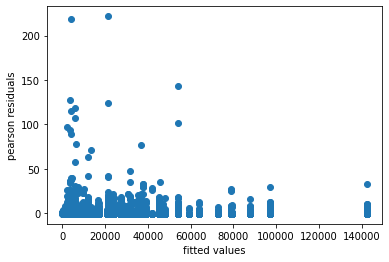

In [6]:
plot_pearson_residuals(df_filtered, model_neg, 0, None)

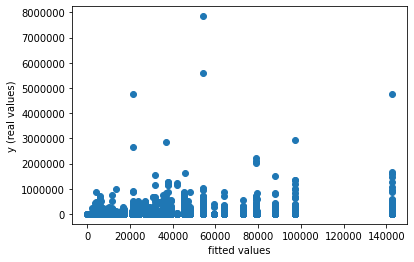

In [7]:
plot_real_vs_fitted(df_filtered, model_neg, log_scale=False)

In [8]:
df_filtered[(df_filtered.views_7_sum > (model_neg.fittedvalues * 20)) & (df_filtered.views_7_sum > 2 * 10 ** 6)]

,event_id,pagetitle,event_date,economic_region,country,continent,cat,categories,views_7_sum,views_before_mean,...,Country/Area,Year,GDP_pc,GDP,oecd,date_month,views_baseline,in_code_lang,in_code_region,views_baseline_cat
229,Q170645,2018 FIFA World Cup,2018-06-14,Global North,Russia,Europe,sports,"['Category:2017–18 in Russian football', 'Cate...",4756233,188749.000000,...,Russia,2018,11372.277988,1.657328e+12,False,2018-06-01,6.418600e+07,False,False,>10^7
384,Q189571,UEFA Euro 2016,2016-06-10,Global North,France,Europe,sports,"['Category:2015–16 in French football', 'Categ...",2663535,118587.428571,...,France,2016,36979.702257,2.471286e+12,True,2016-06-01,9.501500e+07,False,False,>10^7
466,Q20022969,88th Academy Awards,2016-02-28,Global North,United States,North America,culture,"['Category:2015 film awards', 'Category:2016 a...",2095840,53235.857143,...,United States,2016,57876.719077,1.869511e+13,True,2016-02-01,3.429789e+09,True,True,>10^9
736,Q21479779,November 2015 Paris attacks,2015-11-13,Global North,France,Europe,disaster,"['Category:10th arrondissement of Paris', 'Cat...",2931843,0.000000,...,France,2015,36611.753912,2.438208e+12,True,2015-11-01,9.531800e+07,False,False,>10^7
945,Q22076019,89th Academy Awards,2017-02-26,Global North,United States,North America,culture,"['Category:2016 film awards', 'Category:2017 a...",2013088,49717.000000,...,United States,2017,59921.674703,1.947962e+13,True,2017-02-01,3.313535e+09,True,True,>10^9
1117,Q22923830,2020 United States presidential election,2020-11-03,Global North,United States,North America,politics,['Category:2020 United States presidential ele...,7847440,186775.857143,...,United States,2020,63122.594145,2.089375e+13,True,2020-11-01,3.137752e+09,True,True,>10^9
4408,Q47496499,92nd Academy Awards,2020-02-09,Global North,United States,North America,culture,"['Category:2019 film awards', 'Category:2020 a...",2226447,53921.428571,...,United States,2020,63122.594145,2.089375e+13,True,2020-02-01,3.297605e+09,True,True,>10^9
6833,Q699872,2016 United States presidential election,2016-11-08,Global North,United States,North America,politics,['Category:2016 United States presidential ele...,5580333,108.714286,...,United States,2016,57876.719077,1.869511e+13,True,2016-11-01,3.132468e+09,True,True,>10^9
7369,Q8613,2016 Summer Olympics,2016-08-05,Global South,Brazil,South America,sports,"['Category:2010s in Rio de Janeiro', 'Category...",2866833,112068.571429,...,Brazil,2016,8710.063417,1.795693e+12,False,2016-08-01,6.046900e+07,False,False,>10^7
7426,Q95579249,Murder of George Floyd,2020-05-25,Global North,United States,North America,disaster,"['Category:2020 controversies', 'Category:2020...",4748626,0.000000,...,United States,2020,63122.594145,2.089375e+13,True,2020-05-01,3.455160e+09,True,True,>10^9


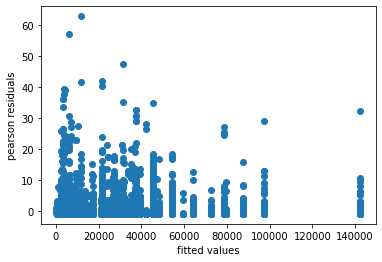

In [9]:
plot_pearson_residuals(df_filtered, model_neg, 15)

# Visualization

In [10]:
from plot_regression import plot_regression_results_interactions_from_dict
from regression import fit_regression_and_rename_coeffs_by_cat

In [20]:
df_filtered.head()

,event_id,pagetitle,event_date,economic_region,country,continent,cat,categories,views_7_sum,views_before_mean,...,Country/Area,Year,GDP_pc,GDP,oecd,date_month,views_baseline,in_code_lang,in_code_region,views_baseline_cat
0,Q100021,Pakistan International Airlines Flight 661,2016-12-07,Global South,Pakistan,Asia,disaster,"['Category:2016 disasters in Pakistan', 'Categ...",248274,0.000000,...,Pakistan,2016,1362.860008,2.775210e+11,False,2016-12-01,8.684000e+07,True,False,>10^7
1,Q100231328,Gretchen Whitmer kidnapping plot,2020-10-08,Global North,United States,North America,disaster,"['Category:2020 crimes in the United States', ...",74144,0.000000,...,United States,2020,63122.594145,2.089375e+13,True,2020-10-01,3.137752e+09,True,True,>10^9
2,Q100256872,Killing of Babu Lal Vaishnav,2020-10-08,Global South,India,Asia,disaster,"['Category:2020 crimes in India', 'Category:20...",427,0.000000,...,India,2020,1930.971218,2.664749e+12,False,2020-10-01,7.142770e+08,True,False,>10^8
3,Q100279235,Miss Vietnam 2020,2020-11-20,Global South,Vietnam,Asia,culture,"['Category:2020 beauty pageants', 'Category:Be...",1444,49.285714,...,Vietnam,2020,2785.724225,2.711584e+11,False,2020-11-01,1.619000e+07,False,False,>10^7
4,Q100288161,2020 Ganja missile attacks,2020-10-11,Global South,Azerbaijan,Asia,disaster,"['Category:2020 in Azerbaijan', 'Category:Arti...",7410,0.000000,...,Azerbaijan,2020,4202.232239,4.260718e+10,False,2020-10-01,3.088000e+06,False,False,>10^6


### Income class * article category
(without and with control for Wikipedia views from event-country: continuous and categorical control)

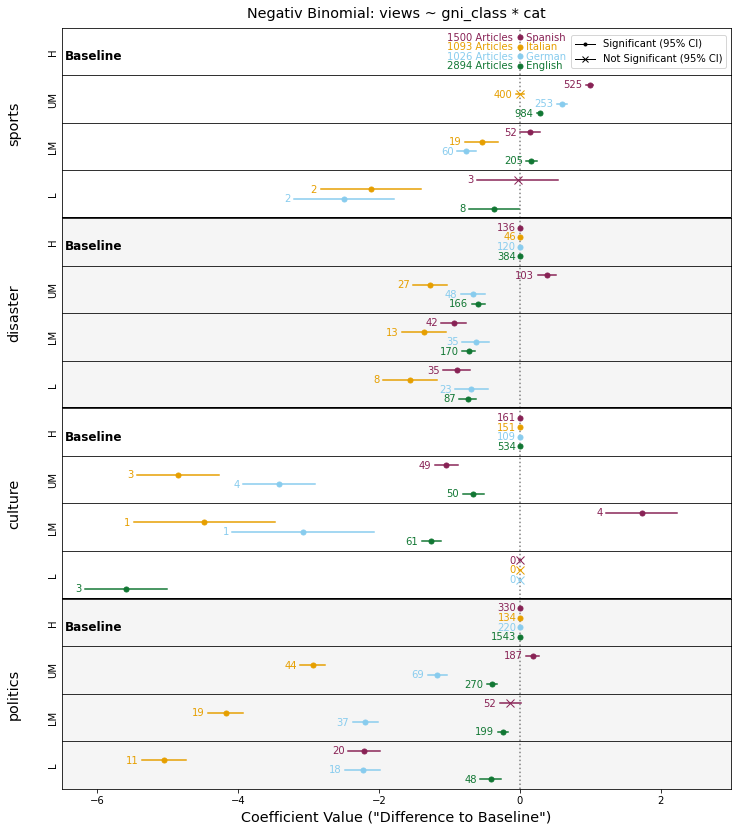

In [11]:
results_fit_separate_class = fit_regression_and_rename_coeffs_by_cat(df_filtered,
                                                                     formula="views_7_sum ~ C(cat, Treatment(reference='sports')) * C(gni_class, Treatment(reference='H'))",
                                                                     type='nb')

fig_int_class_cat_nb = plot_regression_results_interactions_from_dict(df_filtered,
                                                                      results_fit_separate_class, ['cat:gni_class'],
                                                                      {'gni_class': 'H', 'in_code_lang': True,
                                                                       'gni_region': 'North America', 'cat': 'sports',
                                                                       'code': 'en'},
                                                                      label_sort={'gni_class': ['H', 'UM', 'LM', 'L'],
                                                                                  'cat': ['sports', 'disaster',
                                                                                          'culture', 'politics'],
                                                                                  'gni_region': ['North America',
                                                                                                 'Europe & Central Asia',
                                                                                                 'Middle East & North Africa',
                                                                                                 'East Asia & Pacific',
                                                                                                 'South Asia',
                                                                                                 'Latin America & Caribbean',
                                                                                                 'Sub-Saharan Africa']},
                                                                      cat_dict={'en': 'English', 'it': 'Italian',
                                                                                'es': 'Spanish', 'de': 'German'},
                                                                      title='Negativ Binomial: views ~ gni_class * cat',
                                                                      label_rename_dict={
                                                                          'Middle East & North Africa': 'MENAf',
                                                                          'Latin America & Caribbean': 'LatAmC',
                                                                          'Europe & Central Asia': 'EuCAs',
                                                                          'East Asia & Pacific': 'EAsP',
                                                                          'North America': 'NAm',
                                                                          'Sub-Saharan Africa': 'SSAf',
                                                                          'South Asia': 'SAs'},
                                                                      figsize=(12, 14), x_limits=(-6.5, 3),
                                                                      include_counts=True)
fig_int_class_cat_nb.savefig('figures/nb_cat_class.pdf')

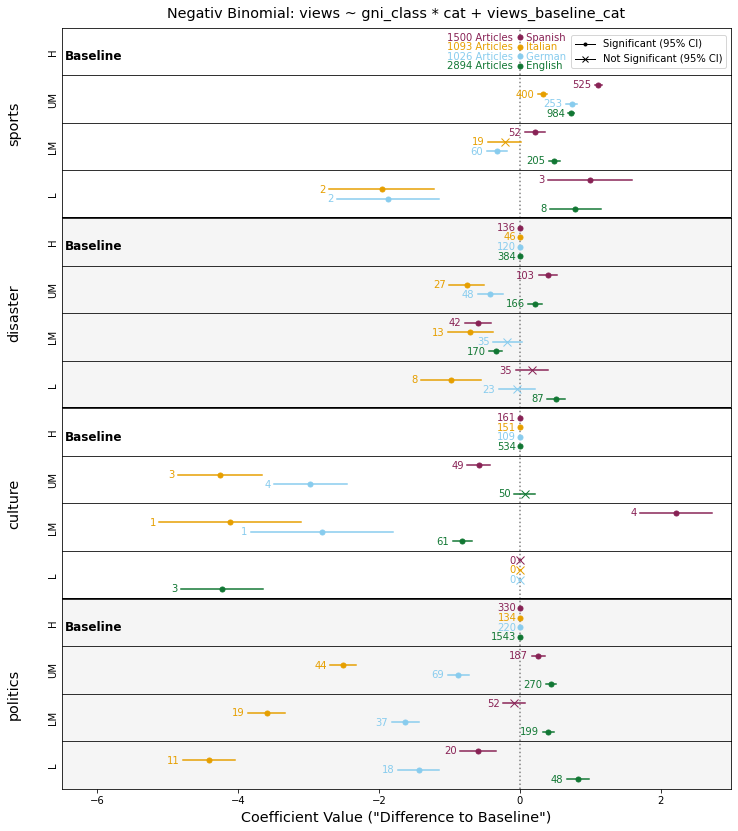

In [12]:
results_fit_separate_class_controlcat = fit_regression_and_rename_coeffs_by_cat(
    df_filtered,
    formula="views_7_sum ~ C(cat, Treatment(reference='sports')) * C(gni_class, Treatment(reference='H')) + C(views_baseline_cat, Treatment(reference='>10^8'))",
    type='nb')

fig_int_class_cat_nb = plot_regression_results_interactions_from_dict(df_filtered,
                                                                      results_fit_separate_class_controlcat,
                                                                      ['cat:gni_class'],
                                                                      {'gni_class': 'H', 'in_code_lang': True,
                                                                       'gni_region': 'North America', 'cat': 'sports',
                                                                       'code': 'en'},
                                                                      label_sort={'gni_class': ['H', 'UM', 'LM', 'L'],
                                                                                  'cat': ['sports', 'disaster',
                                                                                          'culture', 'politics'],
                                                                                  'gni_region': ['North America',
                                                                                                 'Europe & Central Asia',
                                                                                                 'Middle East & North Africa',
                                                                                                 'East Asia & Pacific',
                                                                                                 'South Asia',
                                                                                                 'Latin America & Caribbean',
                                                                                                 'Sub-Saharan Africa']},
                                                                      cat_dict={'en': 'English', 'it': 'Italian',
                                                                                'es': 'Spanish', 'de': 'German'},
                                                                      title='Negativ Binomial: views ~ gni_class * cat + views_baseline_cat',
                                                                      label_rename_dict={
                                                                          'Middle East & North Africa': 'MENAf',
                                                                          'Latin America & Caribbean': 'LatAmC',
                                                                          'Europe & Central Asia': 'EuCAs',
                                                                          'East Asia & Pacific': 'EAsP',
                                                                          'North America': 'NAm',
                                                                          'Sub-Saharan Africa': 'SSAf',
                                                                          'South Asia': 'SAs'},
                                                                      figsize=(12, 14), x_limits=(-6.5, 3),
                                                                      include_counts=True)
fig_int_class_cat_nb.savefig('figures/nb_cat_class_controlcat.pdf')

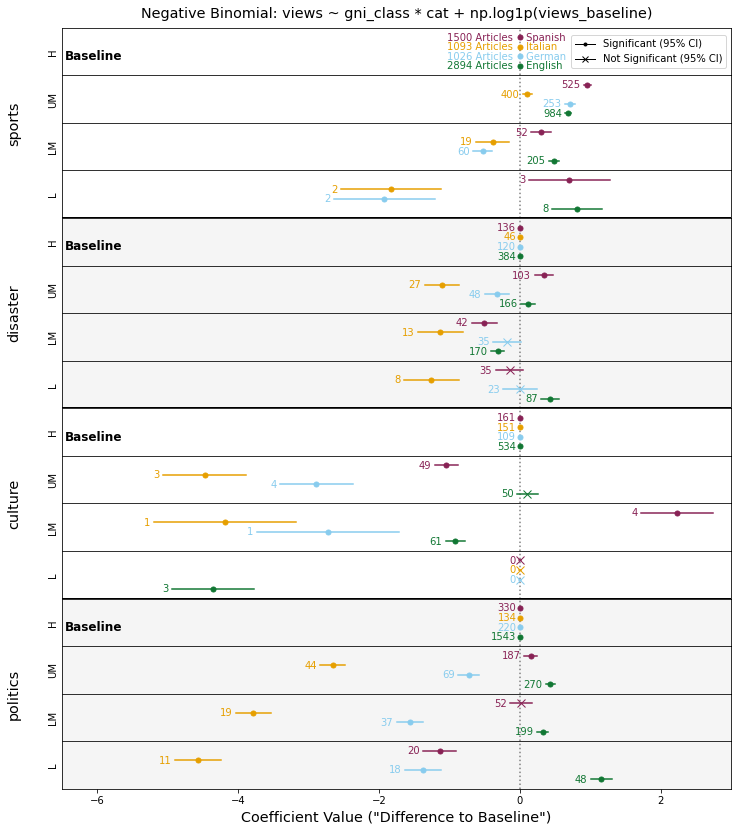

In [13]:
from regression import fit_regression_and_rename_coeffs_by_cat

results_fit_separate_class_control = fit_regression_and_rename_coeffs_by_cat(df_filtered,
                                                                             formula="views_7_sum ~ C(cat, Treatment(reference='sports')) * C(gni_class, Treatment(reference='H')) + np.log1p(views_baseline)",
                                                                             type='nb')

fig_int_class_cat_nb = plot_regression_results_interactions_from_dict(df_filtered,
                                                                      results_fit_separate_class_control,
                                                                      ['cat:gni_class'],
                                                                      {'gni_class': 'H', 'in_code_lang': True,
                                                                       'gni_region': 'North America', 'cat': 'sports',
                                                                       'code': 'en'},
                                                                      label_sort={'gni_class': ['H', 'UM', 'LM', 'L'],
                                                                                  'cat': ['sports', 'disaster',
                                                                                          'culture', 'politics'],
                                                                                  'gni_region': ['North America',
                                                                                                 'Europe & Central Asia',
                                                                                                 'Middle East & North Africa',
                                                                                                 'East Asia & Pacific',
                                                                                                 'South Asia',
                                                                                                 'Latin America & Caribbean',
                                                                                                 'Sub-Saharan Africa']},
                                                                      cat_dict={'en': 'English', 'it': 'Italian',
                                                                                'es': 'Spanish', 'de': 'German'},
                                                                      title='Negative Binomial: views ~ gni_class * cat + np.log1p(views_baseline)',
                                                                      label_rename_dict={
                                                                          'Middle East & North Africa': 'MENAf',
                                                                          'Latin America & Caribbean': 'LatAmC',
                                                                          'Europe & Central Asia': 'EuCAs',
                                                                          'East Asia & Pacific': 'EAsP',
                                                                          'North America': 'NAm',
                                                                          'Sub-Saharan Africa': 'SSAf',
                                                                          'South Asia': 'SAs'},
                                                                      figsize=(12, 14), x_limits=(-6.5, 3),
                                                                      include_counts=True)
fig_int_class_cat_nb.savefig('figures/nb_cat_class_control.pdf')

In [14]:
results_fit_separate_class['en'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            views_7_sum   No. Observations:                 7606
Model:                            GLM   Df Residuals:                     7590
Model Family:        NegativeBinomial   Df Model:                           15
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -87698.
Date:                Tue, 08 Mar 2022   Deviance:                       31200.
Time:                        16:56:52   Pearson chi2:                 1.38e+05
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1487
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          10.2361      0.019    550.648      0.000      10.200      10.272
cat[T.culture]                      0.5643      0.047     11.982      0.000       0.472       0.657
cat[T.disaster]                     1.4249      0.054     26.235      0.000       1.318       1.531
cat[T.politics]                     0.4850      0.032     15.387      0.000       0.423       0.547
gni_class[T.L]                     -0.3719      0.354     -1.050      0.294      -1.066       0.322
gni_class[T.LM]                     0.1645      0.072      2.276      0.023       0.023       0.306
gni_class[T.UM]                     0.2829      0.037      7.665      0.000       0.211       0.355
cat[T.culture]:gni_class[T.L]      -5.2208      0.680     -7.678      0.000      -6.554      -3.888
cat[T.disaster]:gni_class[T.L]     -0.3701      0.373     -0.991      0.322      -1.102       0.362
cat[T.politics]:gni_class[T.L]     -0.0414      0.383     -0.108      0.914      -0.792       0.710
cat[T.culture]:gni_class[T.LM]     -1.4242      0.153     -9.292      0.000      -1.725      -1.124
cat[T.disaster]:gni_class[T.LM]    -0.8932      0.117     -7.628      0.000      -1.123      -0.664
cat[T.politics]:gni_class[T.LM]    -0.4020      0.104     -3.851      0.000      -0.607      -0.197
cat[T.culture]:gni_class[T.UM]     -0.9450      0.152     -6.200      0.000      -1.244      -0.646
cat[T.disaster]:gni_class[T.UM]    -0.8704      0.100     -8.708      0.000      -1.066      -0.675
cat[T.politics]:gni_class[T.UM]    -0.6799      0.076     -8.994      0.000      -0.828      -0.532
===================================================================================================
"""

In [22]:
results_fit_separate_class_control['en'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            views_7_sum   No. Observations:                 7606
Model:                            GLM   Df Residuals:                     7589
Model Family:        NegativeBinomial   Df Model:                           16
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -87098.
Date:                Tue, 08 Mar 2022   Deviance:                       30000.
Time:                        18:55:23   Pearson chi2:                 1.11e+05
No. Iterations:                    16   Pseudo R-squ. (CS):             0.2730
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           6.5107      0.107     61.058      0.000       6.302       6.720
cat[T.culture]                      0.2633      0.047      5.544      0.000       0.170       0.356
cat[T.disaster]                     1.3198      0.055     24.207      0.000       1.213       1.427
cat[T.politics]                     0.3707      0.032     11.545      0.000       0.308       0.434
gni_class[T.L]                      0.8125      0.355      2.287      0.022       0.116       1.509
gni_class[T.LM]                     0.4828      0.073      6.610      0.000       0.340       0.626
gni_class[T.UM]                     0.6824      0.038     18.004      0.000       0.608       0.757
cat[T.culture]:gni_class[T.L]      -5.1694      0.680     -7.602      0.000      -6.502      -3.837
cat[T.disaster]:gni_class[T.L]     -0.3827      0.373     -1.025      0.306      -1.115       0.349
cat[T.politics]:gni_class[T.L]      0.3427      0.383      0.894      0.371      -0.409       1.094
cat[T.culture]:gni_class[T.LM]     -1.3965      0.153     -9.109      0.000      -1.697      -1.096
cat[T.disaster]:gni_class[T.LM]    -0.7938      0.117     -6.778      0.000      -1.023      -0.564
cat[T.politics]:gni_class[T.LM]    -0.1582      0.105     -1.509      0.131      -0.364       0.047
cat[T.culture]:gni_class[T.UM]     -0.5765      0.153     -3.776      0.000      -0.876      -0.277
cat[T.disaster]:gni_class[T.UM]    -0.5656      0.100     -5.641      0.000      -0.762      -0.369
cat[T.politics]:gni_class[T.UM]    -0.2480      0.077     -3.224      0.001      -0.399      -0.097
np.log1p(views_baseline)            0.1917      0.006     34.334      0.000       0.181       0.203
===================================================================================================
"""

### Geographic region * article category
(without and with control for Wikipedia views from event-country: continuous and categorical control)

In [ ]:
results_fit_separate_region = fit_regression_and_rename_coeffs_by_cat(df_filtered,
                                                                      formula="views_7_sum ~ C(cat, Treatment(reference='sports')) * C(gni_region, Treatment(reference='North America'))",
                                                                      type='nb')

fig_int_class_cat_nb = plot_regression_results_interactions_from_dict(df_filtered,
                                                                      results_fit_separate_region, ['cat:gni_region'],
                                                                      {'gni_class': 'H', 'in_code_lang': True,
                                                                       'gni_region': 'North America', 'cat': 'sports',
                                                                       'code': 'en'},
                                                                      label_sort={'gni_class': ['H', 'UM', 'LM', 'L'],
                                                                                  'cat': ['sports', 'disaster',
                                                                                          'culture', 'politics'],
                                                                                  'gni_region': ['North America',
                                                                                                 'Europe & Central Asia',
                                                                                                 'Middle East & North Africa',
                                                                                                 'East Asia & Pacific',
                                                                                                 'South Asia',
                                                                                                 'Latin America & Caribbean',
                                                                                                 'Sub-Saharan Africa']},
                                                                      cat_dict={'en': 'English', 'it': 'Italian',
                                                                                'es': 'Spanish', 'de': 'German'},
                                                                      title='Negative Binomial: views ~ gni_region * cat',
                                                                      label_rename_dict={
                                                                          'Middle East & North Africa': 'MENAf',
                                                                          'Latin America & Caribbean': 'LatAmC',
                                                                          'Europe & Central Asia': 'EuCAs',
                                                                          'East Asia & Pacific': 'EAsP',
                                                                          'North America': 'NAm',
                                                                          'Sub-Saharan Africa': 'SSAf',
                                                                          'South Asia': 'SAs'},
                                                                      figsize=(12, 18), x_limits=(-6.5, 3),
                                                                      include_counts=True)
fig_int_class_cat_nb.savefig('figures/nb_cat_region.pdf')

In [ ]:
results_fit_separate_region = fit_regression_and_rename_coeffs_by_cat(df_filtered,
                                                                      formula="views_7_sum ~ C(cat, Treatment(reference='sports')) * C(gni_region, Treatment(reference='North America')) + np.log1p(views_baseline)",
                                                                      type='nb')

fig_int_class_cat_nb = plot_regression_results_interactions_from_dict(df_filtered,
                                                                      results_fit_separate_region, ['cat:gni_region'],
                                                                      {'gni_class': 'H', 'in_code_lang': True,
                                                                       'gni_region': 'North America', 'cat': 'sports',
                                                                       'code': 'en'},
                                                                      label_sort={'gni_class': ['H', 'UM', 'LM', 'L'],
                                                                                  'cat': ['sports', 'disaster',
                                                                                          'culture', 'politics'],
                                                                                  'gni_region': ['North America',
                                                                                                 'Europe & Central Asia',
                                                                                                 'Middle East & North Africa',
                                                                                                 'East Asia & Pacific',
                                                                                                 'South Asia',
                                                                                                 'Latin America & Caribbean',
                                                                                                 'Sub-Saharan Africa']},
                                                                      cat_dict={'en': 'English', 'it': 'Italian',
                                                                                'es': 'Spanish', 'de': 'German'},
                                                                      title='Negative Binomial: views ~ gni_region * cat + np.log1p(views_baseline)',
                                                                      label_rename_dict={
                                                                          'Middle East & North Africa': 'MENAf',
                                                                          'Latin America & Caribbean': 'LatAmC',
                                                                          'Europe & Central Asia': 'EuCAs',
                                                                          'East Asia & Pacific': 'EAsP',
                                                                          'North America': 'NAm',
                                                                          'Sub-Saharan Africa': 'SSAf',
                                                                          'South Asia': 'SAs'},
                                                                      figsize=(12, 18), x_limits=(-6.5, 3),
                                                                      include_counts=True)
fig_int_class_cat_nb.savefig('figures/nb_cat_region_control.pdf')

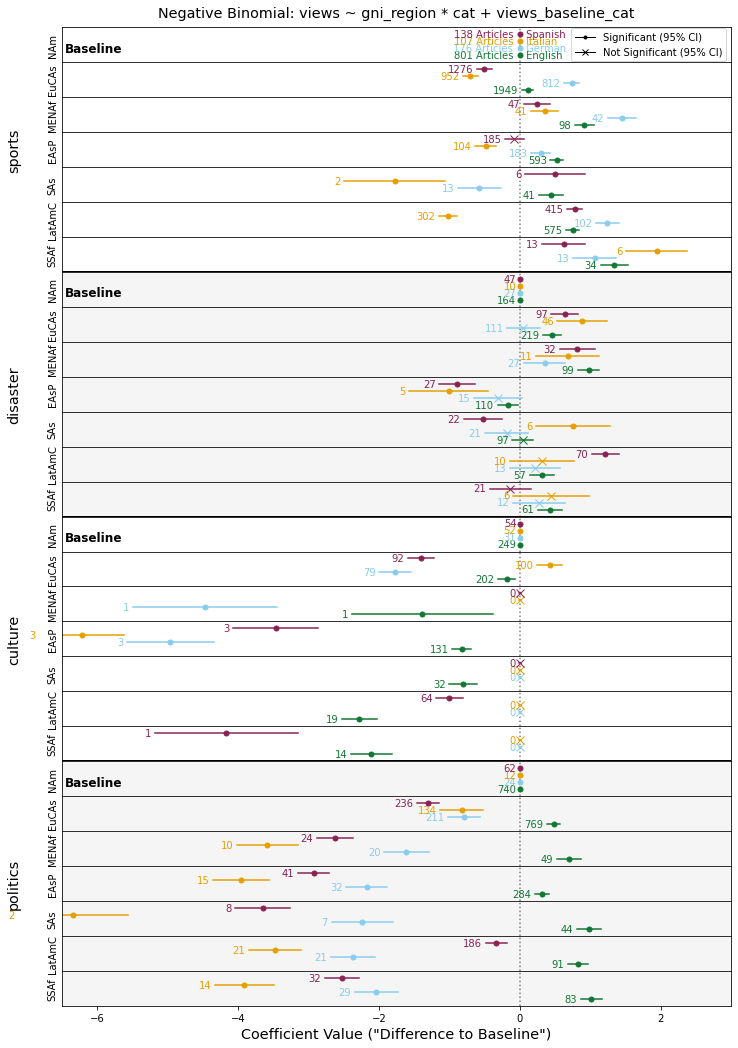

In [21]:
results_fit_separate_region_controlcat = fit_regression_and_rename_coeffs_by_cat(df_filtered,
                                                                                 formula="views_7_sum ~ C(cat, Treatment(reference='sports')) * C(gni_region, Treatment(reference='North America')) + C(views_baseline_cat, Treatment(reference='>10^8'))",
                                                                                 type='nb')

fig_int_class_cat_nb = plot_regression_results_interactions_from_dict(df_filtered,
                                                                      results_fit_separate_region_controlcat,
                                                                      ['cat:gni_region'],
                                                                      {'gni_class': 'H', 'in_code_lang': True,
                                                                       'gni_region': 'North America', 'cat': 'sports',
                                                                       'code': 'en'},
                                                                      label_sort={'gni_class': ['H', 'UM', 'LM', 'L'],
                                                                                  'cat': ['sports', 'disaster',
                                                                                          'culture', 'politics'],
                                                                                  'gni_region': ['North America',
                                                                                                 'Europe & Central Asia',
                                                                                                 'Middle East & North Africa',
                                                                                                 'East Asia & Pacific',
                                                                                                 'South Asia',
                                                                                                 'Latin America & Caribbean',
                                                                                                 'Sub-Saharan Africa']},
                                                                      cat_dict={'en': 'English', 'it': 'Italian',
                                                                                'es': 'Spanish', 'de': 'German'},
                                                                      title='Negative Binomial: views ~ gni_region * cat + views_baseline_cat',
                                                                      label_rename_dict={
                                                                          'Middle East & North Africa': 'MENAf',
                                                                          'Latin America & Caribbean': 'LatAmC',
                                                                          'Europe & Central Asia': 'EuCAs',
                                                                          'East Asia & Pacific': 'EAsP',
                                                                          'North America': 'NAm',
                                                                          'Sub-Saharan Africa': 'SSAf',
                                                                          'South Asia': 'SAs'},
                                                                      figsize=(12, 18), x_limits=(-6.5, 3),
                                                                      include_counts=True)
fig_int_class_cat_nb.savefig('figures/nb_cat_region_controlcat.pdf')

### Other diagnostics

#### Residuals & Residual outliers

In [ ]:
#fig.subplot
fig, axs = plt.subplots(ncols=4, figsize=(15, 3))
plot_pearson_residuals(df_filtered[df_filtered.code == 'de'], results_fit_separate_region['de'], title='de', ax=axs[0])
plot_pearson_residuals(df_filtered[df_filtered.code == 'en'], results_fit_separate_region['en'], title='en', ax=axs[1])
plot_pearson_residuals(df_filtered[df_filtered.code == 'es'], results_fit_separate_region['es'], title='es', ax=axs[2])
plot_pearson_residuals(df_filtered[df_filtered.code == 'it'], results_fit_separate_region['it'], title='it', ax=axs[3])
fig.tight_layout()

In [ ]:
#fig.subplot
fig, axs = plt.subplots(ncols=4, figsize=(15, 3))
plot_pearson_residuals(df_filtered[df_filtered.code == 'de'], results_fit_separate_region['de'], exclude_n_outliers=10,
                       title='de', ax=axs[0])
plot_pearson_residuals(df_filtered[df_filtered.code == 'en'], results_fit_separate_region['en'], exclude_n_outliers=10,
                       title='en', ax=axs[1])
plot_pearson_residuals(df_filtered[df_filtered.code == 'es'], results_fit_separate_region['es'], exclude_n_outliers=10,
                       title='es', ax=axs[2])
plot_pearson_residuals(df_filtered[df_filtered.code == 'it'], results_fit_separate_region['it'], exclude_n_outliers=10,
                       title='it', ax=axs[3])
fig.tight_layout()

#### Actual vs. Fitted values

In [ ]:
#fig.subplot
fig, axs = plt.subplots(ncols=4, figsize=(15, 3))
plot_real_vs_fitted(df_filtered[df_filtered.code == 'de'], results_fit_separate_region['de'], title='de', ax=axs[0])
plot_real_vs_fitted(df_filtered[df_filtered.code == 'en'], results_fit_separate_region['en'], title='en', ax=axs[1])
plot_real_vs_fitted(df_filtered[df_filtered.code == 'es'], results_fit_separate_region['es'], title='es', ax=axs[2])
plot_real_vs_fitted(df_filtered[df_filtered.code == 'it'], results_fit_separate_region['it'], title='it', ax=axs[3])
fig.tight_layout()